In [73]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Flatten
from keras.layers import Conv1D, LSTM, Dropout, Bidirectional,LayerNormalization,SimpleRNN
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [74]:
df = pd.read_csv('./data/stock.csv', index_col=0)

In [75]:
df.columns

Index(['종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

In [76]:
df = df[df['종목명']=='삼성전자']

In [77]:
df = df[['시가','고가','저가','종가']]

In [78]:
df

,시가,고가,저가,종가
일자,,,,
20210601,80500,81300,80100,80600
20210602,80400,81400,80300,80800
20210603,81300,83000,81100,82800
20210604,82700,82700,81500,82200
20210607,82700,82800,81600,81900
...,...,...,...,...
20230523,68500,68700,68100,68400
20230524,68100,68700,68000,68500
20230525,69900,70000,68700,68800


In [79]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

df = MinMaxScaler(df)

In [80]:
dfx = df[['시가','고가','저가']]
dfy = df[['종가']]

dfx.columns = ['Open','High','Low']
dfy.columns = [['Close']]

In [81]:
dfy

,Close
일자,
20210601,0.924092
20210602,0.930693
20210603,0.996700
20210604,0.976898
20210607,0.966997
...,...
20230523,0.521452
20230524,0.524752
20230525,0.534653


In [82]:
time_step = 5
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step):
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v)
        ys.append(labels)

    return np.array(Xs), np.array(ys)

In [83]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(489, 5, 3)

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((342, 5, 3), (147, 5, 3), (342, 1), (147, 1))

In [85]:
model = Sequential()
model.add(SimpleRNN(64,input_shape = (X.shape[1:]), return_sequences=True, activation='relu'))
model.add(SimpleRNN(32, activation='relu'))
model.add(Dense(16))
model.add(Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 5, 64)             4352      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [87]:
history = model.fit(X_train, y_train, epochs=256, batch_size=64, validation_split=0.3, shuffle=False)

Epoch 1/256
4/4 [==============================] - 5s 248ms/step - loss: 0.8433 - mae: 0.8646 - val_loss: 0.0260 - val_mae: 0.1375
Epoch 2/256
4/4 [==============================] - 0s 18ms/step - loss: 0.2109 - mae: 0.4204 - val_loss: 0.0030 - val_mae: 0.0443
Epoch 3/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0258 - mae: 0.1312 - val_loss: 0.0048 - val_mae: 0.0599
Epoch 4/256
4/4 [==============================] - 0s 23ms/step - loss: 0.0097 - mae: 0.0860 - val_loss: 0.0119 - val_mae: 0.1001
Epoch 5/256
4/4 [==============================] - 0s 18ms/step - loss: 0.0202 - mae: 0.1337 - val_loss: 0.0087 - val_mae: 0.0853
Epoch 6/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0061 - mae: 0.0649 - val_loss: 0.0035 - val_mae: 0.0502
Epoch 7/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0028 - mae: 0.0415 - val_loss: 0.0020 - val_mae: 0.0370
Epoch 8/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0064 - mae: 0.0

4/4 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0371
Epoch 64/256
4/4 [==============================] - 0s 21ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0368
Epoch 65/256
4/4 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0293 - val_loss: 0.0020 - val_mae: 0.0366
Epoch 66/256
4/4 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0365
Epoch 67/256
4/4 [==============================] - 0s 19ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0019 - val_mae: 0.0363
Epoch 68/256
4/4 [==============================] - 0s 21ms/step - loss: 0.0015 - mae: 0.0292 - val_loss: 0.0019 - val_mae: 0.0361
Epoch 69/256
4/4 [==============================] - 0s 17ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 0.0019 - val_mae: 0.0359
Epoch 70/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0015 - mae: 0.0291 - 

4/4 [==============================] - 0s 21ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 0.0015 - val_mae: 0.0320
Epoch 126/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0320
Epoch 127/256
4/4 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0320
Epoch 128/256
4/4 [==============================] - 0s 23ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 129/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 130/256
4/4 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 131/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0015 - val_mae: 0.0319
Epoch 132/256
4/4 [==============================] - 0s 27ms/step - loss: 0.0013 - mae: 0.

4/4 [==============================] - 0s 24ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0306
Epoch 188/256
4/4 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 189/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 190/256
4/4 [==============================] - 0s 18ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0014 - val_mae: 0.0305
Epoch 191/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0304
Epoch 192/256
4/4 [==============================] - 0s 20ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0304
Epoch 193/256
4/4 [==============================] - 0s 18ms/step - loss: 0.0012 - mae: 0.0269 - val_loss: 0.0013 - val_mae: 0.0304
Epoch 194/256
4/4 [==============================] - 0s 19ms/step - loss: 0.0012 - mae: 0.

4/4 [==============================] - 0s 31ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 250/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 251/256
4/4 [==============================] - 0s 23ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 252/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 253/256
4/4 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0294
Epoch 254/256
4/4 [==============================] - 0s 23ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0012 - val_mae: 0.0293
Epoch 255/256
4/4 [==============================] - 0s 22ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0012 - val_mae: 0.0293
Epoch 256/256
4/4 [==============================] - 0s 21ms/step - loss: 0.0012 - mae: 0.

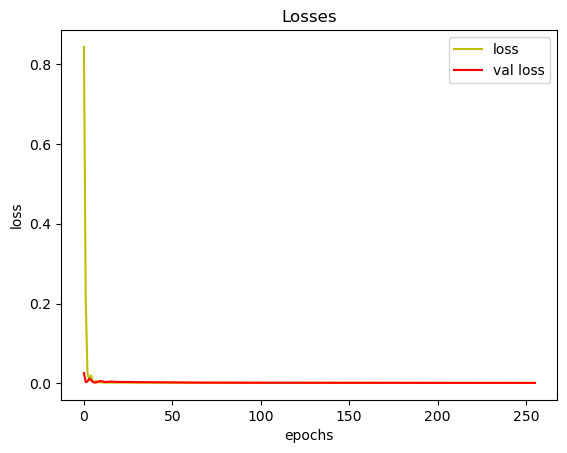

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [89]:
y_pred = model.predict(X_test)

5/5 [==============================] - 1s 3ms/step


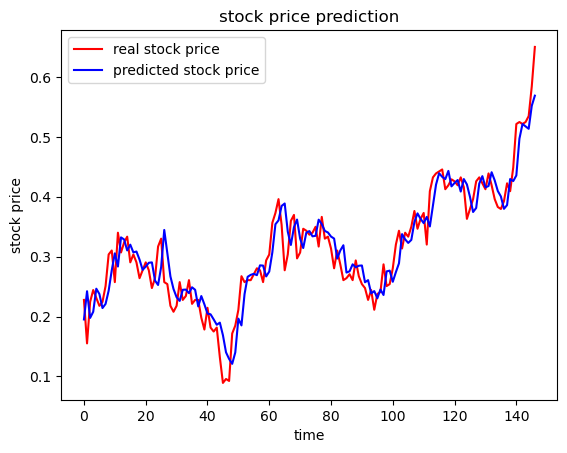

In [90]:
plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()